In [284]:
import nibabel

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

from pydicom import dcmread
from pathlib import Path
from subprocess import check_call
from tqdm import tqdm
from shutil import rmtree


from mri_brain.contours import mask_to_dicom
from dicom_csv import join_tree
from dicom_csv.spatial import order_series
import ants

import dicom_csv
from dicom_csv import join_tree, order_series, stack_images
from pathlib import Path

In [ ]:
import nibabel
import slicer
import matplotlib.pyplot as plt
from pydicom import dcmread

### LGG dataset creation

1. Populate folders with lgg_path.csv - doesn't work because of wrong labels (COR are not in the segmentation)
1.1 Populate only 38 folders and manually check that they are ok
2. Check if there are propeply transferred with saving nii.gz
3. Transfer RT struct
4. Compose rtstruct files into nifty
5. Visually check the data

### Pipeline creating the dataset


1. Cheching nii files
2. Checking the packages dicom
3. Adding rt structure
4. Composing rt structure from dicom to nii

In [2587]:
root = Path('/anvar/public_datasets/tcia/manifest-25ZdsnMy5264093150469993200/TCGA-LGG/')
# df = join_tree(root, verbose=1)
# df.to_csv(root.parent / 'meta.csv', index=False)
# df = pd.read_csv(root.parent / 'meta.csv')

In [ ]:
basedir = '/anvar/public_datasets/tcia/'
savedir = '/anvar/public_datasets/preproc_study/lgg/dicom/'
str(root / subject['PathToFolder'].values[0]).replace(basedir, '')

### Saving RTSTRUCT to each folder

In [253]:
count = 0
for i in os.listdir(root):
    try:
        shutil.copytree(glob.glob('/anvar/public_datasets/tcia/manifest-1588284345182/TCGA-LGG/' + i +'/*/')[0], 
                        '/anvar/public_datasets/lgg/dicom/' + i + '/RTSTRUCT/') 
        count+=1
        print (i)
    except:
        pass

TCGA-CS-6188
TCGA-DU-7015
TCGA-CS-5393
TCGA-DU-8167
TCGA-DU-7306
TCGA-CS-4942
TCGA-CS-6186
TCGA-DU-8164
TCGA-DU-7300
TCGA-DU-7301
TCGA-DU-6404
TCGA-DU-8162
TCGA-DU-7299
TCGA-CS-6668
TCGA-DU-8168
TCGA-DU-5854
TCGA-CS-6666
TCGA-CS-5397
TCGA-CS-4944
TCGA-DU-6542
TCGA-DU-8166
TCGA-DU-5872
TCGA-CS-6665
TCGA-DU-7019
TCGA-DU-7008
TCGA-CS-6669
TCGA-DU-7298
TCGA-DU-7018
TCGA-DU-5855
TCGA-DU-5851
TCGA-DU-7010
TCGA-DU-5874
TCGA-DU-7309
TCGA-DU-7302
TCGA-CS-5396
TCGA-DU-7294
TCGA-DU-7304
TCGA-DU-7014


In [285]:
len(os.listdir('/anvar/public_datasets/preproc_study/lgg/dicom/'))

38

In [267]:
# delete folders w/o RTSTRUCT
for i in os.listdir('/anvar/public_datasets/preproc_study/lgg/dicom/'):
    print(i)
    try:
        print(len(os.listdir('/anvar/public_datasets/preproc_study/lgg/dicom/' + i + '/RTSTRUCT/')))
    except:
        shutil.rmtree('/anvar/public_datasets/preproc_study/lgg/dicom/' +i )

TCGA-CS-6188
9
TCGA-DU-7015
8
TCGA-CS-5393
8
TCGA-DU-8167
8
TCGA-DU-7306
8
TCGA-CS-4942
8
TCGA-CS-6186
8
TCGA-DU-8164
8
TCGA-DU-7300
8
TCGA-DU-5852
TCGA-DU-6400
TCGA-DU-7301
8
TCGA-DU-7013
TCGA-DU-6404
8
TCGA-DU-8162
8
TCGA-DU-7299
8
TCGA-CS-6668
8
TCGA-DU-8168
8
TCGA-DU-5854
8
TCGA-CS-6666
8
TCGA-CS-5397
8
TCGA-DU-6397
TCGA-CS-4944
8
TCGA-DU-6399
TCGA-DU-6408
TCGA-DU-6542
8
TCGA-DU-8166
8
TCGA-DU-5872
8
TCGA-DU-8165
TCGA-DU-5853
TCGA-CS-6665
8
TCGA-DU-7019
8
TCGA-DU-7008
8
TCGA-DU-8163
TCGA-CS-4938
TCGA-CS-4941
TCGA-CS-6669
8
TCGA-DU-7298
8
TCGA-DU-6405
TCGA-CS-5390
TCGA-CS-6290
TCGA-DU-7018
8
TCGA-DU-6410
TCGA-DU-5855
8
TCGA-DU-5851
8
TCGA-DU-7010
8
TCGA-DU-5874
8
TCGA-DU-7309
8
TCGA-CS-5394
TCGA-DU-5871
TCGA-DU-7302
8
TCGA-DU-5849
TCGA-CS-5396
8
TCGA-DU-7294
8
TCGA-DU-8158
TCGA-DU-7304
8
TCGA-CS-6667
TCGA-CS-4943
TCGA-DU-7014
8
TCGA-DU-6395


### Define list of subjects to process

In [ ]:
paths = pd.read_csv('../lgg_paths.csv')

In [296]:
list_sub = os.listdir('/anvar/public_datasets/preproc_study/lgg/dicom/')

In [2259]:
def load_series(sub, root=None):
    """Loads DICOMs in specific order coincided with SegmentationStorage ordering."""
    if isinstance(root, Path):
        return order_series([dcmread(root / file.PathToFolder / file.FileName) for _, file in sub.iterrows()])[::-1]

def get_segmentation_storage_mask(segmentation_storage, subject):
    """Returns (width, height, 3) mask, with values 1,2,3 corresponding to different BraTS classes."""
    chanel_len = len(subject)
    mask = segmentation_storage.pixel_array
    mask = np.transpose(mask, (2,1,0))
    n_channels = np.shape(mask)[2] // chanel_len
    
    if n_channels == 3:
        mask = np.array(np.split(mask, 3, axis=2))
        mask = np.array([1,2,3]).reshape((3, 1, 1, 1)) * mask
    elif n_channels == 2:
        mask = np.array(np.split(mask, 2, axis=2))
        mask = np.array([1,2]).reshape((2, 1, 1, 1)) * mask
    
    print('We have n_channels:', n_channels)
#     return np.flip(mask.sum(axis=0),axis=2) 
    #flips seems to estimated only visually. So I was returning to, if these were not aligned
    return mask.sum(axis=0)

def get_reference_uid(segmentation_storage):
    """Returns reference SeriesInstanceUID of given SegmentationStorage"""
    return str(segmentation_storage.ReferencedSeriesSequence[0][('0020', '000e')].value)

# Starting search:

In [1120]:
# choosing subject
sub = list_sub[0]

T2.nii.gz
/anvar/public_datasets/preproc_study/lgg/orig/TCGA-CS-5393/T2.nii.gz
(512, 512, 20)


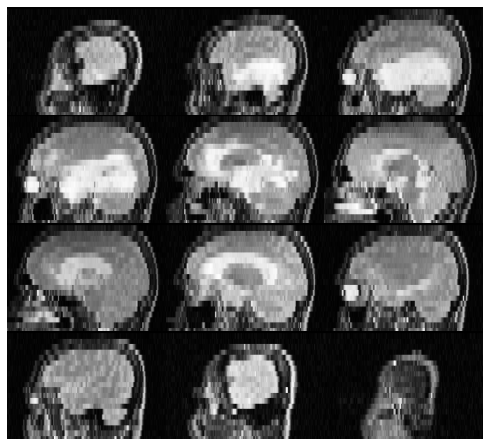

FLAIR.nii.gz
/anvar/public_datasets/preproc_study/lgg/orig/TCGA-CS-5393/FLAIR.nii.gz
(256, 256, 20)


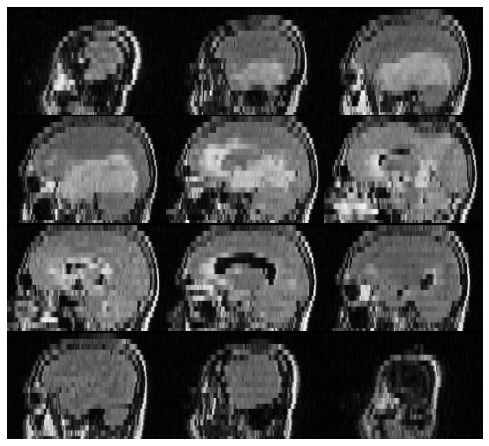

T1.nii.gz
/anvar/public_datasets/preproc_study/lgg/orig/TCGA-CS-5393/T1.nii.gz
(256, 256, 18)


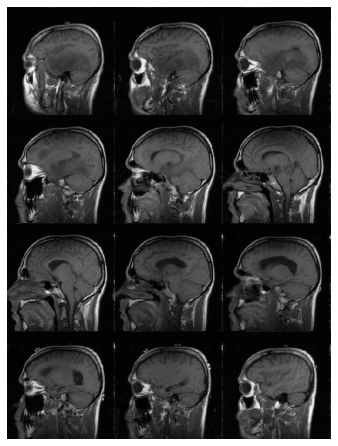

In [1121]:
# checking T2 if saved correctly
for i in os.listdir('/anvar/public_datasets/preproc_study/lgg/orig/'+ sub):
    if i != 'CT1.nii.gz':
        print(i)
        img = ants.image_read('/anvar/public_datasets/preproc_study/lgg/orig/'+ sub +'/'+ i)
        print('/anvar/public_datasets/preproc_study/lgg/orig/'+ sub +'/'+ i)
        print(img.shape)
        ants.plot(img)

## If wrong naming - delete excessive files:

In [1092]:
!sudo cp /anvar/public_datasets/preproc_study/lgg/orig/TCGA-DU-7014/T2_e1.nii.gz /anvar/public_datasets/preproc_study/lgg/orig/TCGA-DU-7014/T2.nii.gz

In [1093]:
# deleting files
!sudo rm /anvar/public_datasets/preproc_study/lgg/orig/TCGA-DU-7014/T2_e1.nii.gz

## SAVING CT1 retstruct

In [2570]:
# choosing subject
sub = list_sub[18]


# checking what rt structure you want
rt_basedir = '/anvar/public_datasets/preproc_study/lgg/dicom/' + sub + '/RTSTRUCT'
list_rt_struct = os.listdir(rt_basedir)
list_rt_struct_corrected = [s for s in list_rt_struct if 'Corrected' in s]
list_rt_struct_corrected 

['300.000000-BRAINSTRYKERT1AXIAL Glioma Segmentation Corrected-32318',
 '300.000000-BRAINSTRYKERFLAIR Glioma Segmentation Corrected-29897',
 '300.000000-BRAINNONCONTRASTFL2DA Glioma Segmentation Corrected-52878']

## Attention:

In [2571]:
# поменять по порядку в корректер, нумерация яс 0
rtstruct_subfolder = rt_basedir + '/'+ list_rt_struct_corrected[0]
print(rtstruct_subfolder)
df_rt = dicom_csv.join_tree(rtstruct_subfolder)

/anvar/public_datasets/preproc_study/lgg/dicom/TCGA-CS-4944/RTSTRUCT/300.000000-BRAINSTRYKERT1AXIAL Glioma Segmentation Corrected-32318


In [2572]:
rtstruct_dicom_folder = rtstruct_subfolder + '/1-1.dcm'
save_folder = Path(rtstruct_subfolder.replace(rtstruct_subfolder.split('/')[-1],'') + 'CT1/')
try:
    shutil.rmtree(save_folder)
except:
    pass
Path.mkdir(save_folder, exist_ok=True)
segmentation_storage = dcmread(rtstruct_dicom_folder)

reference_uid = get_reference_uid(segmentation_storage)
subject = df.query('SeriesInstanceUID==@reference_uid')
path_to_ct1 = df.query('SeriesInstanceUID==@reference_uid')['PathToFolder'].iloc[0]

image_series = load_series(subject, root)
print(path_to_ct1, len(subject)) 

mask = get_segmentation_storage_mask(segmentation_storage, subject)
mask_to_dicom(image_series, mask, folder=save_folder)  

TCGA-CS-4944/02-08-2001-JHN BRAIN-IP-65472/3.000000-BRAINSTRYKERT1AXIAL-13550 20
We have n_channels: 2


нужно теперь проверить, что СТ1 мы нужный сохранили, и его можно собрать в другую папку допустим:

### checking saved CT1

In [2588]:
ct1_folder_file = os.listdir(str((Path(rtstruct_subfolder.replace('RTSTRUCT/'+rtstruct_subfolder.split('/')[-1],'') + 'CT1/'))))
ct1_folder = (rtstruct_subfolder.replace('RTSTRUCT/'+rtstruct_subfolder.split('/')[-1],'') + 'CT1/')

if (os.listdir(ct1_folder)) != os.listdir(str(root / path_to_ct1)):
    print('hi')
    shutil.rmtree(ct1_folder)
    Path.mkdir(Path(ct1_folder), exist_ok=True)
    for i in (os.listdir(str(root / path_to_ct1))):
        shutil.copy(str(root / path_to_ct1) + '/' + i, ct1_folder)
#check if transfereed correcntly        
(os.listdir(ct1_folder)) == os.listdir(str(root / path_to_ct1))

True

In [2597]:
os.remove('/anvar/public_datasets/preproc_study/lgg/dicom/' +sub+ '/CT1_SEG.nii.gz')
os.remove('/anvar/public_datasets/preproc_study/lgg/orig/' +sub+ '/CT1/')

FileNotFoundError: [Errno 2] No such file or directory: '/anvar/public_datasets/preproc_study/lgg/orig/TCGA-CS-4944/CT1.nii.gz'

In [2540]:
!dcm2niix -b n -f CT1_SEG -z y -o /anvar/public_datasets/preproc_study/lgg/orig/TCGA${sub}/ /anvar/public_datasets/preproc_study/lgg/dicom/TCGA${sub}/RTSTRUCT/CT1/

Chris Rorden's dcm2niiX version v1.0.20211006  GCC9.3.0 x86-64 (64-bit Linux)
Found 20 DICOM file(s)
Convert 20 DICOM as /anvar/public_datasets/preproc_study/lgg/orig/TCGA-CS-4944/CT1_SEG (256x256x20x1)
Compress: "/usr/bin/pigz" -b 960 -n -f -6 "/anvar/public_datasets/preproc_study/lgg/orig/TCGA-CS-4944/CT1_SEG.nii"
Conversion required 0.027862 seconds (0.017277 for core code).


In [2566]:
!dcm2niix -b n -f CT1 -z y -o /anvar/public_datasets/preproc_study/lgg/orig/TCGA${sub}/ /anvar/public_datasets/preproc_study/lgg/dicom/TCGA${sub}/CT1/

Chris Rorden's dcm2niiX version v1.0.20211006  GCC9.3.0 x86-64 (64-bit Linux)
Found 20 DICOM file(s)
Convert 20 DICOM as /anvar/public_datasets/preproc_study/lgg/orig/TCGA-CS-4944/CT1 (256x256x20x1)
Compress: "/usr/bin/pigz" -b 960 -n -f -6 "/anvar/public_datasets/preproc_study/lgg/orig/TCGA-CS-4944/CT1.nii"
Conversion required 0.096355 seconds (0.016656 for core code).


# DONE

In [2615]:
list_sub[13]

'TCGA-CS-6668'

In [2617]:
sub = list_sub[13]         
ct1 = ants.image_read('/anvar/public_datasets/preproc_study/lgg/orig/' + sub + '/CT1.nii.gz')
ct1_seg = ants.image_read('/anvar/public_datasets/preproc_study/lgg/orig/' + sub + '/CT1_SEG.nii.gz')
# flair = ants.image_read('/anvar/public_datasets/preproc_study/lgg/1_reg/' + sub + '/FLAIR.nii.gz')
# flair = ants.reorient_image2(flair, ct1.get_orientation())
slice3d(ct1.numpy(), np.flip(ct1_seg.numpy(),axis =2))

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=169), Output()), _dom…

In [2544]:
ct1_nii = ants.image_read(
    glob.glob('/anvar/public_datasets/tcia/Pre-operative_TCGA_LGG_NIfTI_and_Segmentations/' + sub + '/*_t1Gd.nii.gz')[0])
ct1_nii = ants.reorient_image2(ct1_nii, ct1.get_orientation())

flair_nii = ants.image_read(
    glob.glob('/anvar/public_datasets/tcia/Pre-operative_TCGA_LGG_NIfTI_and_Segmentations/' + sub + '/*_flair.nii.gz')[0])
flair_nii = ants.reorient_image2(flair_nii, ct1.get_orientation())

ct1_seg_nii = ants.image_read(
    glob.glob('/anvar/public_datasets/tcia/Pre-operative_TCGA_LGG_NIfTI_and_Segmentations/' + sub + '/*_GlistrBoost_ManuallyCorrected.nii.gz')[0])
ct1_seg_nii = ants.reorient_image2(ct1_seg_nii, ct1.get_orientation())

slice3d(ct1_nii.numpy(), flair_nii.numpy(), ct1_seg_nii.numpy())

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=239), Output()), _dom…

In [2618]:
# saving with flip
os.remove('/anvar/public_datasets/preproc_study/lgg/orig/' +sub+ '/CT1_SEG.nii.gz')
flipped_ct1_seg = ct1_seg.new_image_like(np.flip(ct1_seg.numpy(), axis= 2))
ants.image_write(flipped_ct1_seg, '/anvar/public_datasets/preproc_study/lgg/orig/' + sub + '/CT1_SEG.nii.gz', ri=False)

In [2619]:
shutil.rmtree('/anvar/public_datasets/preproc_study/lgg/1_reg/' + sub)

In [2620]:
sub

'TCGA-CS-6668'

### checking if naming is unclear

In [1882]:
images2d = [dcmread(root / row[1].PathToFolder / row[1].FileName) for row in df.query('SeriesInstanceUID==@reference_uid').iterrows()] 
image3d = stack_images(order_series(images2d))

mask = segmentation_storage.pixel_array
print(np.shape(mask))
mask = np.transpose(mask,(2,1,0))
print(np.unique(mask))
print(np.shape(mask))


mask = np.array(np.split(mask, 2, axis=2))
print(np.shape(mask))
print(np.unique(mask))
mask = np.array([1,2]).reshape((2, 1, 1, 1)) * mask
slice3d(image3d+ np.flip(mask.sum(axis=0),axis=2)*200)

# mask = np.array(np.split(mask, 3, axis=2))
# print(np.shape(mask))
# print(np.unique(mask))
# mask = np.array([1,2,3]).reshape((3, 1, 1, 1)) * mask
# # slice3d(image3d, mask.sum(axis=0))
# slice3d(image3d, np.flip(mask.sum(axis=0),axis=2))

(40, 256, 256)
[0 1]
(256, 256, 40)
(2, 256, 256, 20)
[0 1]


interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=19), Output()), _dom_…

In [1865]:
### Delete old CT1:
for sub in os.listdir('/anvar/public_datasets/preproc_study/lgg/orig1/'):
    shutil.copyfile('/anvar/public_datasets/preproc_study/lgg/orig/' + sub + '/T2.nii.gz', '/anvar/public_datasets/preproc_study/lgg/orig1/' + sub + '/T2.nii.gz')
    shutil.copyfile('/anvar/public_datasets/preproc_study/lgg/orig/' + sub + '/FLAIR.nii.gz', '/anvar/public_datasets/preproc_study/lgg/orig1/' + sub + '/FLAIR.nii.gz')
    shutil.copyfile('/anvar/public_datasets/preproc_study/lgg/orig/' + sub + '/T1.nii.gz', '/anvar/public_datasets/preproc_study/lgg/orig1/' + sub + '/T1.nii.gz')

FileNotFoundError: [Errno 2] No such file or directory: '/anvar/public_datasets/preproc_study/lgg/orig1/'

In [1883]:
#os.remove('/anvar/public_datasets/preproc_study/lgg/orig/TCGA-CS-4944' + list_sub[37] + '/CT1.nii.gz')

In [1884]:
!dcm2niix -b n -f CT1 -z y -o /anvar/public_datasets/preproc_study/lgg/orig/TCGA-CS-4944/ /anvar/public_datasets/preproc_study/lgg/dicom/TCGA-CS-4944/CT1/

Chris Rorden's dcm2niiX version v1.0.20211006  GCC9.3.0 x86-64 (64-bit Linux)
Found 20 DICOM file(s)
Convert 20 DICOM as /anvar/public_datasets/preproc_study/lgg/orig/TCGA-CS-4944/CT1g (256x256x20x1)
Compress: "/usr/bin/pigz" -b 960 -n -f -6 "/anvar/public_datasets/preproc_study/lgg/orig/TCGA-CS-4944/CT1g.nii"
Conversion required 0.089499 seconds (0.015087 for core code).


In [1885]:
!dcm2niix -b n -f CT1_SEG -z y -o /anvar/public_datasets/preproc_study/lgg/orig/TCGA-CS-4944/ /anvar/public_datasets/preproc_study/lgg/dicom/TCGA-CS-4944/RTSTRUCT/CT1/

Chris Rorden's dcm2niiX version v1.0.20211006  GCC9.3.0 x86-64 (64-bit Linux)
Found 20 DICOM file(s)
Convert 20 DICOM as /anvar/public_datasets/preproc_study/lgg/orig/TCGA-CS-4944/CT1_SEGg (256x256x20x1)
Compress: "/usr/bin/pigz" -b 960 -n -f -6 "/anvar/public_datasets/preproc_study/lgg/orig/TCGA-CS-4944/CT1_SEGg.nii"
Conversion required 0.026363 seconds (0.015370 for core code).


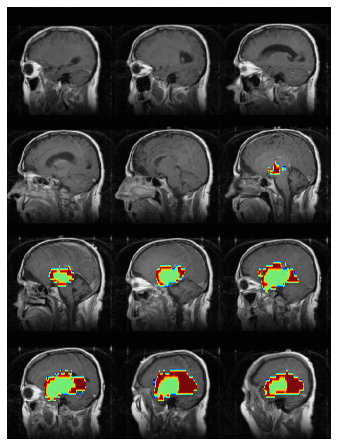

In [1886]:
import ants

ants.plot(ants.image_read('/anvar/public_datasets/preproc_study/lgg/orig/TCGA-CS-4944/CT1.nii.gz'),
         ants.image_read('/anvar/public_datasets/preproc_study/lgg/orig/TCGA-CS-4944/CT1_SEG.nii.gz'))

In [1887]:
ct1_orig = ants.image_read('/anvar/public_datasets/preproc_study/lgg/orig/TCGA-CS-4944/CT1.nii.gz')
seg_orig = ants.image_read('/anvar/public_datasets/preproc_study/lgg/orig/TCGA-CS-4944/CT1_SEG.nii.gz')

ct1_1_reg = ants.image_read('/anvar/public_datasets/preproc_study/lgg/1_reg/TCGA-CS-4944/CT1.nii.gz')
seg_1_reg = ants.image_read('/anvar/public_datasets/preproc_study/lgg/1_reg/TCGA-CS-4944/CT1_SEG.nii.gz')

ct1_4a_resamp =  ants.resample_image(ct1_1_reg, (1, 1, 1), False)
seg_4a =  ants.resample_image(seg_1_reg, (1, 1, 1), False)

In [1888]:
slice3d(ct1_orig.numpy(), seg_orig.numpy())

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=19), Output()), _dom_…

In [1761]:
seg_orig

ANTsImage (RPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (256, 256, 20)
	 Spacing    : (0.8594, 0.8594, 7.5)
	 Origin     : (-106.184, 121.1758, -79.2837)
	 Direction  : [ 1.  0.  0.  0. -1.  0.  0.  0.  1.]

In [1764]:
ct1_4a_resamp 

ANTsImage (RPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (135, 240, 240)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (-61.6099, 128.2798, -129.9235)
	 Direction  : [ 1.  0.  0.  0. -1.  0.  0.  0.  1.]

In [1765]:
seg_4a

ANTsImage (RPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (220, 220, 150)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (-106.184, 121.1758, -79.2837)
	 Direction  : [ 1.  0.  0.  0. -1.  0.  0.  0.  1.]

In [1757]:
ct1_1_reg

ANTsImage (RPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (20, 256, 256)
	 Spacing    : (6.75, 0.9375, 0.9375)
	 Origin     : (-61.6099, 128.2798, -129.9235)
	 Direction  : [ 1.  0.  0.  0. -1.  0.  0.  0.  1.]

In [1753]:
seg_1_reg

ANTsImage (RPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (256, 256, 20)
	 Spacing    : (0.8594, 0.8594, 7.5)
	 Origin     : (-106.184, 121.1758, -79.2837)
	 Direction  : [ 1.  0.  0.  0. -1.  0.  0.  0.  1.]

In [1758]:
slice3d(ct1_1_reg.numpy(),seg_1_reg.numpy())

ValueError: Arrays of equal size along axis -1 are required: (256,), (20,)

In [1723]:
for sub in os.listdir('/anvar/public_datasets/preproc_study/lgg/orig1/'):
    print(sub, os.listdir('/anvar/public_datasets/preproc_study/lgg/orig1/'+sub))

TCGA-CS-6188 ['T2.nii.gz', 'FLAIR.nii.gz', 'T1.nii.gz', 'CT1_SEG.nii.gz', 'CT1.nii.gz']
TCGA-DU-7015 ['T2.nii.gz', 'FLAIR.nii.gz', 'T1.nii.gz', 'CT1_SEG.nii.gz', 'CT1.nii.gz']
TCGA-CS-5393 ['T2.nii.gz', 'FLAIR.nii.gz', 'T1.nii.gz', 'CT1_SEG.nii.gz', 'CT1.nii.gz']
TCGA-DU-8167 ['T2.nii.gz', 'FLAIR.nii.gz', 'T1.nii.gz', 'CT1_SEG.nii.gz', 'CT1.nii.gz']
TCGA-DU-7306 ['T2.nii.gz', 'FLAIR.nii.gz', 'T1.nii.gz', 'CT1_SEG.nii.gz', 'CT1.nii.gz']
TCGA-CS-4942 ['T2.nii.gz', 'FLAIR.nii.gz', 'T1.nii.gz', 'CT1_SEG.nii.gz', 'CT1.nii.gz']
TCGA-CS-6186 ['T2.nii.gz', 'FLAIR.nii.gz', 'T1.nii.gz', 'CT1_SEG.nii.gz', 'CT1.nii.gz']
TCGA-DU-8164 ['T2.nii.gz', 'FLAIR.nii.gz', 'T1.nii.gz', 'CT1_SEG.nii.gz', 'CT1.nii.gz']
TCGA-DU-7300 ['T2.nii.gz', 'FLAIR.nii.gz', 'T1.nii.gz', 'CT1_SEG.nii.gz', 'CT1.nii.gz']
TCGA-DU-7301 ['T2.nii.gz', 'FLAIR.nii.gz', 'T1.nii.gz', 'CT1_SEG.nii.gz', 'CT1.nii.gz']
TCGA-DU-6404 ['T2.nii.gz', 'FLAIR.nii.gz', 'T1.nii.gz', 'CT1_SEG.nii.gz', 'CT1.nii.gz']
TCGA-DU-8162 ['T2.nii.gz', 'FLAI

## Save *.nii into orig

In [301]:
# contrast image
print(paths['T1C'][paths['ID'] == sub].values[0].split('/')[-1])

In [417]:
# all images
glob.glob('/anvar/public_datasets/tcia/manifest-25ZdsnMy5264093150469993200/TCGA-LGG/'+ sub+ '/*/*/')

In [419]:
root / subject['PathToFolder'].values[0]

PosixPath('/anvar/public_datasets/tcia/manifest-25ZdsnMy5264093150469993200/TCGA-LGG/TCGA-CS-4942/02-22-1997-MRI BRAIN WITHO-04689/301.000000-T1 AX  SE-14936')

In [ ]:
### Checking 

### Lets plot CT1 with RT

In [423]:
ct1_img = ants.image_read('/anvar/public_datasets/preproc_study/lgg/orig/'+ sub +'/CT1.nii.gz')
slice3d(ct1_img.numpy())

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=18), Output()), _dom_…

In [422]:
images2d = [dcmread(root / row[1].PathToFolder / row[1].FileName) for row in df.query('SeriesInstanceUID==@reference_uid').iterrows()] 
image3d = stack_images(order_series(images2d))
slice3d(image3d)

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=19), Output()), _dom_…

# DONE

### Checking pachages:

In [391]:
glob.glob('/anvar/public_datasets/preproc_study/lgg/dicom/*/RTSTRUCT/CT1')

['/anvar/public_datasets/preproc_study/lgg/dicom/TCGA-CS-6188/RTSTRUCT/CT1',
 '/anvar/public_datasets/preproc_study/lgg/dicom/TCGA-DU-7015/RTSTRUCT/CT1',
 '/anvar/public_datasets/preproc_study/lgg/dicom/TCGA-CS-5393/RTSTRUCT/CT1',
 '/anvar/public_datasets/preproc_study/lgg/dicom/TCGA-DU-8167/RTSTRUCT/CT1',
 '/anvar/public_datasets/preproc_study/lgg/dicom/TCGA-DU-7306/RTSTRUCT/CT1']

In [222]:
ls /anvar/public_datasets/preproc_study/lgg/orig/TCGA-CS-6188/

CT1.nii.gz  FLAIR.nii.gz  T1.nii.gz  T2.nii.gz


In [346]:
os.listdir('/anvar/public_datasets/preproc_study/lgg/orig/')

['TCGA-CS-6188',
 'TCGA-DU-6401',
 'TCGA-DU-7015',
 'TCGA-CS-5393',
 'TCGA-DU-8167',
 'TCGA-DU-7306',
 'TCGA-CS-4942',
 'TCGA-CS-6186',
 'TCGA-DU-8164',
 'TCGA-DU-A5TP',
 'TCGA-DU-6402',
 'TCGA-CS-5395',
 'TCGA-DU-7300',
 'TCGA-CS-6670',
 'TCGA-DU-6407',
 'TCGA-DU-5852',
 'TCGA-DU-6400',
 'TCGA-DU-7301',
 'TCGA-DU-7013',
 'TCGA-DU-6404',
 'TCGA-DU-8162',
 'TCGA-DU-7299',
 'TCGA-CS-6668',
 'TCGA-DU-8168',
 'TCGA-DU-5854',
 'TCGA-CS-6666',
 'TCGA-CS-5397',
 'TCGA-DU-6397',
 'TCGA-CS-4944',
 'TCGA-DU-6399',
 'TCGA-DU-6408',
 'TCGA-DU-6542',
 'TCGA-DU-8166',
 'TCGA-DU-5872',
 'TCGA-DU-8165',
 'TCGA-DU-5853',
 'TCGA-CS-6665',
 'TCGA-DU-7019',
 'TCGA-DU-7008',
 'TCGA-DU-8163',
 'TCGA-CS-4938',
 'TCGA-CS-4941',
 'TCGA-CS-6669',
 'TCGA-DU-7298',
 'TCGA-DU-6405',
 'TCGA-CS-5390',
 'TCGA-CS-6290',
 'TCGA-DU-7018',
 'TCGA-DU-6410',
 'TCGA-DU-5855',
 'TCGA-DU-5851',
 'TCGA-DU-7010',
 'TCGA-DU-5874',
 'TCGA-DU-7309',
 'TCGA-CS-5394',
 'TCGA-DU-5871',
 'TCGA-DU-7302',
 'TCGA-DU-5849',
 'TCGA-CS-5396

In [224]:
!dicom2niix -b n -f CT1_SEG -z y -o /anvar/public_datasets/preproc_study/lgg/orig/TCGA-CS-6188/ /anvar/public_datasets/preproc_study/lgg/dicom/TCGA-CS-6188/RTSTRUCT/CT1

Chris Rorden's dcm2niiX version v1.0.20211006  GCC9.3.0 x86-64 (64-bit Linux)
Error: Unable to write to output folder: /anvar/public_datasets/preproc_study/lgg/orig/TCGA-CS-6188


In [56]:
# I will print choosen files and find out if they are in segmentation folder by equal naming
count = 0

for i in list_sub:
     
    print(i)
    print('------')
    t1_name = paths[paths['ID'] == i]['T1'].values[0].split('/')[-1]
    t2_name = paths[paths['ID'] == i]['T2'].values[0].split('/')[-1]
    fl_name = paths[paths['ID'] == i]['FLAIR'].values[0].split('/')[-1]
    ct1_name = paths[paths['ID'] == i]['T1C'].values[0].split('/')[-1] 
    
    print('Chosen folders', 'T1', paths[paths['ID'] == i]['T1'].values[0].split('/')[-1] )
    print('Chosen folders', 'T2', paths[paths['ID'] == i]['T2'].values[0].split('/')[-1] )
    print('Chosen folders', 'CT1', paths[paths['ID'] == i]['T1C'].values[0].split('/')[-1] )
    print('Chosen folders', 'FLAIR', paths[paths['ID'] == i]['FLAIR'].values[0].split('/')[-1] )
    
    
    print('------')
    for j in glob.glob('/anvar/public_datasets/tcia/manifest-25ZdsnMy5264093150469993200/TCGA-LGG/'+ i+ '/*/*/'):
        print(j.split('/')[-2], ',', len(os.listdir(j)))
    print('------')    
    for k in glob.glob('/anvar/public_datasets/tcia/manifest-1588284345182/TCGA-LGG/'+ i+ '/*/*/'):
        print(ct1_name.split('000000-')[-1][:-6], k.split('/')[-2], ',', len(os.listdir(k)))
        if ct1_name.split('000000-')[-1][:-6] in k and 'Corrected' in k:
            print('! hi  !')
            count +=1

TCGA-CS-6188
------
Chosen folders T1 401.000000-T1W  SE-32641
Chosen folders T2 701.000000-T2WTSE-87223
Chosen folders CT1 1301.000000-T1 SAG SE-56552
Chosen folders FLAIR 501.000000-T2 AX FLAIR-27780
------
401.000000-T1W  SE-32641 , 16
801.000000-PDWTSE-07186 , 24
1201.000000-T1 COR SE-51898 , 20
303.000000-eBo-77466 , 28
701.000000-T2WTSE-87223 , 24
1101.000000-T1 AX SE-51279 , 24
601.000000-FFE FOR BLEED-26809 , 30
901.000000-T1 AX  SE-53708 , 24
302.000000-dADC MAP-81598 , 28
501.000000-T2 AX FLAIR-27780 , 28
1001.000000-T1W3Dstryker-91068 , 200
1002.000000-COR MPR-65881 , 200
1301.000000-T1 SAG SE-56552 , 16
304.000000-eB1000i-99314 , 28
1003.000000-SAG MRP-30691 , 180
------
T1 SAG SE 300.000000-T1W  SE Glioma Segmentation-80190 , 1
T1 SAG SE 300.000000-T2 AX FLAIR Glioma Segmentation Corrected-08132 , 1
T1 SAG SE 300.000000-COR MPR Glioma Segmentation Corrected-80713 , 1
T1 SAG SE 300.000000-T2WTSE Glioma Segmentation Corrected-41846 , 1
T1 SAG SE 300.000000-T2WTSE Glioma Segm

501.000000-DTI 2.6mm WH-21034 , 70
6.000000-AXIAL DIFFUSION-45058 , 185
10.000000-AX T1 POST GD FLAIR-02819 , 72
5.000000-DTI 2.6mm WH-89883 , 1820
7.000000-AX T2 FR-FSE RF2 150-94767 , 37
9.000000-AXIAL PERFUSION-65144 , 1045
502.000000-DTI 2.6mm WH-17893 , 70
1.000000-3 PLANE LOC-57309 , 9
500.000000-DTI 2.6mm WH-85224 , 70
3.000000-SAG T1 FLAIR-50361 , 21
4.000000-AXIAL FLAIR-03012 , 72
11.000000-COR  T1 POST GD FLAIR-90691 , 40
2.000000-ASSET cal-34016 , 35
------
COR  T1 POST GD FLAIR 300.000000-AXIAL FLAIR Glioma Segmentation Corrected-78372 , 1
COR  T1 POST GD FLAIR 300.000000-AX T1 POST GD FLAIR Glioma Segmentation-28506 , 1
COR  T1 POST GD FLAIR 300.000000-AXIAL FLAIR Glioma Segmentation-46699 , 1
COR  T1 POST GD FLAIR 300.000000-AX T1 pre gd Glioma Segmentation-36852 , 1
COR  T1 POST GD FLAIR 300.000000-AX T1 pre gd Glioma Segmentation Corrected-80275 , 1
COR  T1 POST GD FLAIR 300.000000-AX T1 POST GD FLAIR Glioma Segmentation Corrected-58812 , 1
COR  T1 POST GD FLAIR 300.000

700.000000-DTI ASSET-28396 , 28
4.000000-AXIAL DIFFUSION-48283 , 72
3.000000-SAG T1 FLAIR-02642 , 18
2.000000-ASSET cal-69637 , 40
9.000000-AXIAL PERFUSION-04700 , 855
8.000000-AX T1 pre gd-86144 , 36
1.000000-3 PLANE LOC-15093 , 15
10.000000-AX T1 POST GD FLAIR-49564 , 72
702.000000-DTI ASSET-13763 , 28
11.000000-COR  T1 POST GD FLAIR-28103 , 46
6.000000-AX T2 FR-FSE RF2 150-11418 , 36
701.000000-DTI ASSET-39610 , 28
7.000000-DTI ASSET-72031 , 728
5.000000-AXIAL FLAIR-03289 , 72
------
COR  T1 POST GD FLAIR 300.000000-AX T1 pre gd Glioma Segmentation Corrected-28600 , 1
COR  T1 POST GD FLAIR 300.000000-AX T1 POST GD FLAIR Glioma Segmentation Corrected-50521 , 1
COR  T1 POST GD FLAIR 300.000000-AXIAL FLAIR Glioma Segmentation Corrected-23588 , 1
COR  T1 POST GD FLAIR 300.000000-AXIAL FLAIR Glioma Segmentation-87330 , 1
COR  T1 POST GD FLAIR 300.000000-AX T2 FR-FSE RF2 150 Glioma Segmentation Corrected-44684 , 1
COR  T1 POST GD FLAIR 300.000000-AX T2 FR-FSE RF2 150 Glioma Segmentation-1

4.000000-DTI 2.6mm WH-31825 , 1794
7.000000-AXIAL FLAIR-20431 , 72
5.000000-SAG T1 FLAIR-78070 , 20
400.000000-DTI 2.6mm WH-23321 , 69
3.000000-SAG T1 FLAIR-69643 , 20
------
COR  T1 POST GD FLAIR 300.000000-AX T1 pre gd Glioma Segmentation Corrected-20567 , 1
COR  T1 POST GD FLAIR 300.000000-AX T2 FR-FSE RF2 150 Glioma Segmentation-04249 , 1
COR  T1 POST GD FLAIR 300.000000-AX T1 POST GD FLAIR Glioma Segmentation-12341 , 1
COR  T1 POST GD FLAIR 300.000000-AX T1 pre gd Glioma Segmentation-09635 , 1
COR  T1 POST GD FLAIR 300.000000-AXIAL FLAIR Glioma Segmentation Corrected-69150 , 1
COR  T1 POST GD FLAIR 300.000000-AX T1 POST GD FLAIR Glioma Segmentation Corrected-42912 , 1
COR  T1 POST GD FLAIR 300.000000-AXIAL FLAIR Glioma Segmentation-57864 , 1
COR  T1 POST GD FLAIR 300.000000-AX T2 FR-FSE RF2 150 Glioma Segmentation Corrected-26441 , 1
TCGA-DU-5872
------
Chosen folders T1 2.000000-SAG T1-50574
Chosen folders T2 602.000000-T2-weighted trace-53911
Chosen folders CT1 14.000000-COR T1 

5.000000-AXIAL DTI-25576 , 728
500.000000-AXIAL DTI-27245 , 28
8.000000-Ax T1 2.5mm for surgery-37553 , 65
9.000000-COR T1 POST GD-63027 , 40
2.000000-SAG T1-20114 , 24
1.000000-3 PLANE LOC-33657 , 9
------
COR T1 POST GD 300.000000-Ax FLAIR 2.5mm for surgery Glioma Segmentation Correc-61520 , 1
COR T1 POST GD 300.000000-AXIAL T1 Glioma Segmentation-64199 , 1
COR T1 POST GD 300.000000-AXIAL T1 Glioma Segmentation Corrected-02983 , 1
COR T1 POST GD 300.000000-Ax FLAIR 2.5mm for surgery Glioma Segmentation-12511 , 1
COR T1 POST GD 300.000000-AXIAL FSE Glioma Segmentation-64747 , 1
COR T1 POST GD 300.000000-Ax T1 2.5mm for surgery Glioma Segmentation Corrected-85039 , 1
COR T1 POST GD 300.000000-AXIAL FSE Glioma Segmentation Corrected-46098 , 1
COR T1 POST GD 300.000000-Ax T1 2.5mm for surgery Glioma Segmentation-29966 , 1
TCGA-DU-6405
------
Chosen folders T1 5.000000-AXIAL T1 SI LOCALIZER-35706
Chosen folders T2 2.000000-AXIAL  FSE-09681
Chosen folders CT1 10.000000-AXIAL T1 POST GD-525

5.000000-DTI 2.6mm WH-75602 , 1820
1.000000-3 PLANE LOC-74330 , 9
9.000000-AX T1 pre gd-21019 , 38
6.000000-AXIAL DIFFUSION-49261 , 190
12.000000-AX T1 POST GD FLAIR-53586 , 72
13.000000-COR  T1 POST GD FLAIR-06706 , 48
502.000000-DTI 2.6mm WH-25208 , 70
10.000000-3D DCE T1 MAPPING X 5-75063 , 96
2.000000-3 PLANE LOC-07157 , 9
3.000000-ASSET cal-41727 , 43
------
TCGA-CS-5396
------
Chosen folders T1 501.000000-T1W  SE-58849
Chosen folders T2 701.000000-T2WTSE-70754
Chosen folders CT1 1301.000000-T1 SAG SE-45175
Chosen folders FLAIR 601.000000-T2 AX FLAIR-98890
------
403.000000-eBo-48146 , 28
901.000000-FFE FOR BLEED-67362 , 30
304.000000-LT COW-25699 , 20
1101.000000-T1 AX SE-54608 , 24
302.000000-3D MOTSA sense-85827 , 3
404.000000-eB1000i-30080 , 28
303.000000-COW-38870 , 20
1301.000000-T1 SAG SE-45175 , 16
501.000000-T1W  SE-58849 , 16
306.000000-POSTERIOR-47371 , 20
801.000000-PDWTSE-64364 , 24
301.000000-3D MOTSA sense-80049 , 140
1201.000000-T1 COR SE-91770 , 22
1001.000000-T1 

In [57]:
for i in os.listdir('')

8

In [63]:
paths = pd.read_csv('../lgg_paths.csv')
basedir = '/anvar/public_datasets/tcia/'
savedir = '/anvar/public_datasets/preproc_study/lgg/dicom/'
# os.makedirs('/anvar/public_datasets/preproc_study/lgg/dicom/')

In [22]:
import shutil

for i in range(0, len(paths)):
    print(paths['ID'].iloc[i])
    try:
        os.mkdir(basedir + paths['ID'].iloc[i])
        shutil.copytree(basedir + paths['T1'].iloc[i][1:], savedir + paths['ID'].iloc[i] + '/T1/') 
        shutil.copytree(basedir + paths['T1C'].iloc[i][1:], savedir + paths['ID'].iloc[i] + '/CT1/') 
        shutil.copytree(basedir + paths['T2'].iloc[i][1:], savedir + paths['ID'].iloc[i] + '/T2') 
        shutil.copytree(basedir + paths['FLAIR'].iloc[i][1:], savedir + paths['ID'].iloc[i] + '/FLAIR/')
        
    except OSError as error:
        print(error) 
        pass  

TCGA-DU-7019
[Errno 17] File exists: '/anvar/public_datasets/tcia/TCGA-DU-7019'
TCGA-DU-7302
[Errno 17] File exists: '/anvar/public_datasets/tcia/TCGA-DU-7302'
TCGA-DU-5852
[Errno 17] File exists: '/anvar/public_datasets/tcia/TCGA-DU-5852'
TCGA-DU-7014
[Errno 17] File exists: '/anvar/public_datasets/tcia/TCGA-DU-7014'
TCGA-CS-6669
[Errno 17] File exists: '/anvar/public_datasets/tcia/TCGA-CS-6669'
TCGA-DU-6405
[Errno 17] File exists: '/anvar/public_datasets/tcia/TCGA-DU-6405'
TCGA-DU-5851
[Errno 17] File exists: '/anvar/public_datasets/tcia/TCGA-DU-5851'
TCGA-DU-5854
[Errno 17] File exists: '/anvar/public_datasets/tcia/TCGA-DU-5854'
TCGA-DU-6408
[Errno 17] File exists: '/anvar/public_datasets/tcia/TCGA-DU-6408'
TCGA-DU-5874
[Errno 17] File exists: '/anvar/public_datasets/tcia/TCGA-DU-5874'
TCGA-CS-5396
[Errno 17] File exists: '/anvar/public_datasets/tcia/TCGA-CS-5396'
TCGA-DU-7306
[Errno 17] File exists: '/anvar/public_datasets/tcia/TCGA-DU-7306'
TCGA-CS-5393
[Errno 17] File exists: '/a

In [23]:
os.listdir('/anvar/public_datasets/preproc_study/lgg/')

['dicom', 'orig', 'meta.csv']

#### Проверяем, что нифти файлы корректно сохранились и считаем, сколько их:

In [24]:
print ('T1', len(glob.glob('/anvar/public_datasets/preproc_study/lgg/orig/*/T1.nii.gz')))
print ('T2', len(glob.glob('/anvar/public_datasets/preproc_study/lgg/orig/*/T2.nii.gz')))
print ('FLAIR', len(glob.glob('/anvar/public_datasets/preproc_study/lgg/orig/*/FLAIR.nii.gz')))
print ('CT1', len(glob.glob('/anvar/public_datasets/preproc_study/lgg/orig/*/CT1.nii.gz')))

T1 66
T2 40
FLAIR 64
CT1 66


Опять потерялись T2, из за разного нейминга, попробуем сначала собрать ртструктуры, а потом будем чистить папку

#### Как найти нужную ртструктуру?

- Можно или сделать через поиск похожего нейминга, убрав цифры

- Или можно сделать через по series ID, как и было

In [25]:
os.listdir(rtdir + paths['ID'].iloc[1])

['12-03-1991-MRI BRAIN WWO CONTRAST-41440']

In [26]:
basedir = '/anvar/public_datasets/tcia/'

In [27]:
os.listdir(basedir + paths['T1C'].iloc[i][1:])

['1-38.dcm',
 '1-51.dcm',
 '1-36.dcm',
 '1-01.dcm',
 '1-16.dcm',
 '1-20.dcm',
 '1-03.dcm',
 '1-35.dcm',
 '1-34.dcm',
 '1-09.dcm',
 '1-44.dcm',
 '1-14.dcm',
 '1-04.dcm',
 '1-49.dcm',
 '1-54.dcm',
 '1-12.dcm',
 '1-52.dcm',
 '1-47.dcm',
 '1-22.dcm',
 '1-06.dcm',
 '1-28.dcm',
 '1-17.dcm',
 '1-33.dcm',
 '1-05.dcm',
 '1-50.dcm',
 '1-24.dcm',
 '1-39.dcm',
 '1-15.dcm',
 '1-31.dcm',
 '1-30.dcm',
 '1-32.dcm',
 '1-10.dcm',
 '1-41.dcm',
 '1-45.dcm',
 '1-25.dcm',
 '1-18.dcm',
 '1-07.dcm',
 '1-29.dcm',
 '1-48.dcm',
 '1-11.dcm',
 '1-08.dcm',
 '1-13.dcm',
 '1-43.dcm',
 '1-27.dcm',
 '1-53.dcm',
 '1-40.dcm',
 '1-21.dcm',
 '1-02.dcm',
 '1-19.dcm',
 '1-42.dcm',
 '1-26.dcm',
 '1-23.dcm',
 '1-37.dcm',
 '1-46.dcm',
 '1-55.dcm']

In [28]:
os.listdir('/anvar/public_datasets/tcia/manifest-1588284345182/TCGA-LGG/TCGA-DU-7302/12-03-1991-MRI BRAIN WWO CONTRAST-41440/')

['300.000000-AXIAL FLAIR Glioma Segmentation Corrected-95461',
 '300.000000-AXIAL FLAIR Glioma Segmentation-48843',
 '300.000000-AX T2 FR-FSE RF2 150 Glioma Segmentation-67602',
 '300.000000-AX T1 POST GD FLAIR Glioma Segmentation Corrected-46118',
 '300.000000-AX T2 FR-FSE RF2 150 Glioma Segmentation Corrected-36048',
 '300.000000-AX T1 pre gd Glioma Segmentation-10229',
 '300.000000-AX T1 POST GD FLAIR Glioma Segmentation-41682',
 '300.000000-AX T1 pre gd Glioma Segmentation Corrected-10339']

In [29]:
for i in range(0, len(paths)):
    print(paths['ID'].iloc[i])
    try:
#         os.mkdir(savedir + paths['ID'].iloc[i] + '/')
        print(glob.glob(rtdir + paths['ID'].iloc[i] +'/*/'))
        shutil.copytree(glob.glob(rtdir + paths['ID'].iloc[i] +'/*/')[0], savedir + paths['ID'].iloc[i] + '/RTSTRUCT/') 
      
    except Exception as error:
        print(error) 
        pass  

TCGA-DU-7019
['/anvar/public_datasets/tcia/manifest-1588284345182/TCGA-LGG/TCGA-DU-7019/09-08-1994-MRI BRAIN WWO CONTRAST-36813/']
TCGA-DU-7302
['/anvar/public_datasets/tcia/manifest-1588284345182/TCGA-LGG/TCGA-DU-7302/12-03-1991-MRI BRAIN WWO CONTRAST-41440/']
TCGA-DU-5852
[]
list index out of range
TCGA-DU-7014
['/anvar/public_datasets/tcia/manifest-1588284345182/TCGA-LGG/TCGA-DU-7014/06-18-1986-TUMOR VOL.- WAND-80617/']
TCGA-CS-6669
['/anvar/public_datasets/tcia/manifest-1588284345182/TCGA-LGG/TCGA-CS-6669/01-02-2002-MRI BRAIN COMBO-45633/']
TCGA-DU-6405
[]
list index out of range
TCGA-DU-5851
['/anvar/public_datasets/tcia/manifest-1588284345182/TCGA-LGG/TCGA-DU-5851/04-28-1995-MRI BRAIN WWO CONTRAST-02930/']
TCGA-DU-5854
['/anvar/public_datasets/tcia/manifest-1588284345182/TCGA-LGG/TCGA-DU-5854/11-04-1995-MRI BRAIN WWO CONTRAST-28000/']
TCGA-DU-6408
[]
list index out of range
TCGA-DU-5874
['/anvar/public_datasets/tcia/manifest-1588284345182/TCGA-LGG/TCGA-DU-5874/05-10-1995-MRI BRAI

In [30]:
len(glob.glob('/anvar/public_datasets/preproc_study/lgg/dicom/*/RTSTRUCT/'))

38

In [33]:
len(glob.glob('/anvar/public_datasets/preproc_study/lgg/dicom/*/RTSTRUCT/*/1-1.dcm'))

304

### Running script to compose *.nii images in folders

In [34]:
root = Path('/anvar/public_datasets/preproc_study/lgg/dicom')
df = join_tree(root, verbose=1)
df.to_csv(root.parent / 'meta.csv', index=False)
df = pd.read_csv(root.parent / 'meta.csv')


0it [00:00, ?it/s]
27it [00:00, 260.71it/s]
11407it [09:18, 20.42it/s] 

65it [00:01, 31.90it/s] 
91it [00:01, 43.23it/s]
126it [00:01, 58.65it/s]
162it [00:01, 78.31it/s]
198it [00:01, 102.26it/s]
234it [00:01, 130.19it/s]
270it [00:02, 160.74it/s]
306it [00:02, 192.64it/s]
340it [00:02, 219.58it/s]
374it [00:02, 202.00it/s]
403it [00:02, 205.71it/s]
430it [00:02, 208.55it/s]
455it [00:02, 210.41it/s]
479it [00:02, 211.73it/s]
503it [00:04, 51.86it/s] 
525it [00:04, 67.18it/s]
547it [00:04, 84.69it/s]
572it [00:04, 105.53it/s]
602it [00:04, 130.41it/s]
631it [00:04, 156.18it/s]
657it [00:05, 64.49it/s] 
681it [00:05, 82.31it/s]
703it [00:05, 100.83it/s]
725it [00:05, 119.66it/s]
746it [00:06, 137.38it/s]
767it [00:06, 153.01it/s]
788it [00:07, 47.96it/s] 
810it [00:07, 62.42it/s]
832it [00:07, 79.13it/s]
853it [00:07, 97.26it/s]
874it [00:07, 115.91it/s]
895it [00:07, 133.83it/s]
917it [00:07, 150.34it/s]
938it [00:08, 164.25it/s]
959it [00:09, 49.60it/s] 
974it [00:09, 52.38it/s]
99

In [35]:
paths = pd.read_csv('../lgg_paths.csv')
basedir = '/anvar/public_datasets/tcia/'
savedir = '/anvar/public_datasets/preproc_study/lgg/dicom/'

In [36]:
rtdir = '/anvar/public_datasets/tcia/manifest-1588284345182/TCGA-LGG/'

In [37]:
os.listdir(rtdir+'TCGA-FG-6689/03-26-2002-NR MRI BRAIN WWO-47983') 

['300.000000-MP RAGE AXIAL Glioma Segmentation Corrected-17638',
 '300.000000-MP RAGE AXIAL Glioma Segmentation-71597',
 '300.000000-T2 AXIALS Glioma Segmentation Corrected-93218',
 '300.000000-T2 AXIALS Glioma Segmentation-67348',
 '300.000000-MP RAGE AXIAL Glioma Segmentation-01663',
 '300.000000-MP RAGE AXIAL Glioma Segmentation Corrected-59980',
 '300.000000-FLAIR AXIALS Glioma Segmentation-48998',
 '300.000000-FLAIR AXIALS Glioma Segmentation Corrected-19647']

### Check *dcm files

In [38]:
def load_series(sub, root=None):
    """Loads DICOMs in specific order coincided with SegmentationStorage ordering."""
    if isinstance(root, Path):
        return order_series([dcmread(root / file.PathToFolder / file.FileName) for _, file in sub.iterrows()])[::-1]
    
def get_segmentation_storage_mask(segmentation_storage):
    """Returns (width, height, 3) mask, with values 1,2,3 corresponding to different BraTS classes."""
    mask = segmentation_storage.pixel_array
    mask = np.transpose(mask, (2,1,0))
    mask = np.array(np.split(mask, 3, axis=2))
    mask = np.array([1,2,3]).reshape((3, 1, 1, 1)) * mask
    return mask.sum(axis=0)

def get_reference_uid(segmentation_storage):
    """Returns reference SeriesInstanceUID of given SegmentationStorage"""
    return str(segmentation_storage.ReferencedSeriesSequence[0][('0020', '000e')].value)

def check_if_ct1_ref(df, rref):
    """Checks if input segmentation storage has CT1 image as reference."""
    sub = df.query('SeriesInstanceUID==@rref')
    return sub.PathToFolder.iloc[0].split('/')[1] == 'CT1'

In [39]:
os.listdir(str(root) + '/TCGA-DU-7014/CT1')

['1-4.dcm', '1-1.dcm', '1-2.dcm', '1-3.dcm']

In [40]:
for i in range(8):
    print( 
        get_segmentation_storage_mask( 
            dcmread(str(root) + '/'+ list_seg['PathToFolder'].iloc[i] + '/1-1.dcm')
        ).shape
    )

IndexError: single positional indexer is out-of-bounds

In [41]:
df['SeriesInstanceUID'].value_counts()

1.3.6.1.4.1.14519.5.2.1.4591.4003.125577399578922720346879420953    325
1.3.6.1.4.1.14519.5.2.1.4591.4003.112592252232666023998953315710    180
1.3.6.1.4.1.14519.5.2.1.1188.4001.142459179818453226386988487183    170
1.3.6.1.4.1.14519.5.2.1.1188.4001.114078538471828186024243211217    170
1.3.6.1.4.1.14519.5.2.1.1188.4001.223094313796547802976465712442    170
                                                                   ... 
1.2.276.0.7230010.3.1.3.8323329.408739.1540933534.631625              1
1.2.276.0.7230010.3.1.3.8323329.407667.1540933532.431172              1
1.2.276.0.7230010.3.1.3.8323329.407669.1540933532.487109              1
1.2.276.0.7230010.3.1.3.8323329.408726.1540933534.642854              1
1.2.276.0.7230010.3.1.3.8323329.423577.1540933574.890161              1
Name: SeriesInstanceUID, Length: 567, dtype: int64

In [42]:
def get_segmentation_storage_mask(segmentation_storage):
    """Returns (width, height, 3) mask, with values 1,2,3 corresponding to different BraTS classes."""
    mask = segmentation_storage.pixel_array
    mask = np.transpose(mask, (2,1,0))
    mask = np.array(np.split(mask, 3, axis=2))
    mask = np.array([1,2,3]).reshape((3, 1, 1, 1)) * mask
    return mask.sum(axis=0)

get_segmentation_storage_mask(segmentation_storage)

NameError: name 'segmentation_storage' is not defined

In [ ]:
## поменять название рт структур

In [43]:
segmentation_storage

NameError: name 'segmentation_storage' is not defined

In [295]:
for i in glob.glob('/anvar/public_datasets/preproc_study/lgg/dicom/*/RTSTRUCT_DICOM/'):
#     print(len(os.listdir(i)))
#     shutil.rmtree(i)

In [279]:
os.listdir('/anvar/public_datasets/preproc_study/lgg/dicom/TCGA-CS-5393')

['T1', 'T2', 'CT1', 'RTSTRUCT', 'FLAIR']

In [280]:
# # Only save CT1 (=T1c) mask, `Corrected`

for patient_folder in tqdm(root.glob('*')): # 1
    if any('RTSTRUCT' in subfolders.name for subfolders in patient_folder.glob('*')):
        rtstruct_dicom_folder = patient_folder / 'RTSTRUCT_DICOM'
        if not rtstruct_dicom_folder.exists(): # 2
            rtstruct_dicom_folder.mkdir()
        (rtstruct_dicom_folder / 'CT1').mkdir()

66it [00:00, 13969.72it/s]


### В лоб получается только 2 пациента:

In [44]:
for patient_folder in tqdm(root.glob('*')): 
    rtstruct_dicom_folder = patient_folder / 'RTSTRUCT_DICOM' / 'CT1'
    try:
        for rtstruct_subfolder in (patient_folder / 'RTSTRUCT').glob('*'):
            segmentation_storage = dcmread(rtstruct_subfolder / '1-1.dcm')
            reference_uid = get_reference_uid(segmentation_storage)
#             print(patient_folder.name,reference_uid)
#             if (check_if_ct1_ref(df, reference_uid) and
#                (('Correc' in rtstruct_subfolder.name) or
#                  (patient_folder.name in no_corrected))): # Mask is for CT1 and corrected
            sub = df.query('SeriesInstanceUID==@reference_uid')
            image_series = load_series(sub, root)
            mask = get_segmentation_storage_mask(segmentation_storage)
            mask_to_dicom(image_series, mask, folder=rtstruct_dicom_folder)  
            print(rtstruct_subfolder)
    except Exception as e:
        print(e, patient_folder.name)

1it [00:00,  9.61it/s]

[Errno 2] No such file or directory: '/anvar/public_datasets/preproc_study/lgg/dicom/TCGA-CS-6188/RTSTRUCT_DICOM/CT1/1.3.6.1.4.1.14519.5.2.1.1188.4001.197209226708094868373592418268.dcm' TCGA-CS-6188


3it [00:03,  1.88it/s]

[Errno 2] No such file or directory: '/anvar/public_datasets/preproc_study/lgg/dicom/TCGA-DU-7015/RTSTRUCT_DICOM/CT1/1.3.6.1.4.1.14519.5.2.1.4591.4003.143871386280277404877552456776.dcm' TCGA-DU-7015
not enough values to unpack (expected 1, got 0) TCGA-CS-5393


11711it [03:17, 59.27it/s] 
6it [00:04,  2.60it/s]

[Errno 2] No such file or directory: '/anvar/public_datasets/preproc_study/lgg/dicom/TCGA-DU-8167/RTSTRUCT_DICOM/CT1/1.3.6.1.4.1.14519.5.2.1.4591.4003.187241221374848102675027746350.dcm' TCGA-DU-8167
not enough values to unpack (expected 1, got 0) TCGA-DU-7306
not enough values to unpack (expected 1, got 0) TCGA-CS-4942


8it [00:04,  3.17it/s]

not enough values to unpack (expected 1, got 0) TCGA-CS-6186


9it [00:05,  2.21it/s]

[Errno 2] No such file or directory: '/anvar/public_datasets/preproc_study/lgg/dicom/TCGA-DU-8164/RTSTRUCT_DICOM/CT1/1.3.6.1.4.1.14519.5.2.1.4591.4003.166535749119509005765958353854.dcm' TCGA-DU-8164
not enough values to unpack (expected 1, got 0) TCGA-DU-7300


18it [00:05,  3.07it/s]

not enough values to unpack (expected 1, got 0) TCGA-DU-7301


20it [00:05,  3.61it/s]

[Errno 2] No such file or directory: '/anvar/public_datasets/preproc_study/lgg/dicom/TCGA-DU-6404/RTSTRUCT_DICOM/CT1/1.3.6.1.4.1.14519.5.2.1.4591.4003.137096880648957505008635548973.dcm' TCGA-DU-6404
not enough values to unpack (expected 1, got 0) TCGA-DU-8162


22it [00:05,  4.38it/s]

not enough values to unpack (expected 1, got 0) TCGA-DU-7299
[Errno 2] No such file or directory: '/anvar/public_datasets/preproc_study/lgg/dicom/TCGA-CS-6668/RTSTRUCT_DICOM/CT1/1.3.6.1.4.1.14519.5.2.1.1188.4001.509561857834004889654707831255.dcm' TCGA-CS-6668


24it [00:07,  2.79it/s]

[Errno 2] No such file or directory: '/anvar/public_datasets/preproc_study/lgg/dicom/TCGA-DU-8168/RTSTRUCT_DICOM/CT1/1.3.6.1.4.1.14519.5.2.1.4591.4003.116222340630775448264639214172.dcm' TCGA-DU-8168


25it [00:07,  2.39it/s]

[Errno 2] No such file or directory: '/anvar/public_datasets/preproc_study/lgg/dicom/TCGA-DU-5854/RTSTRUCT_DICOM/CT1/1.3.6.1.4.1.14519.5.2.1.4591.4003.194232179039509028019618459302.dcm' TCGA-DU-5854


26it [00:08,  2.83it/s]

[Errno 2] No such file or directory: '/anvar/public_datasets/preproc_study/lgg/dicom/TCGA-CS-6666/RTSTRUCT_DICOM/CT1/1.3.6.1.4.1.14519.5.2.1.1188.4001.105534766428793796910469125685.dcm' TCGA-CS-6666


29it [00:08,  3.73it/s]

[Errno 2] No such file or directory: '/anvar/public_datasets/preproc_study/lgg/dicom/TCGA-CS-5397/RTSTRUCT_DICOM/CT1/1.3.6.1.4.1.14519.5.2.1.1188.4001.286289311732876264951383337107.dcm' TCGA-CS-5397
[Errno 2] No such file or directory: '/anvar/public_datasets/preproc_study/lgg/dicom/TCGA-CS-4944/RTSTRUCT_DICOM/CT1/1.3.6.1.4.1.14519.5.2.1.1188.4001.146945640367465726951695455981.dcm' TCGA-CS-4944


32it [00:08,  4.90it/s]

not enough values to unpack (expected 1, got 0) TCGA-DU-6542
not enough values to unpack (expected 1, got 0) TCGA-DU-8166


34it [00:08,  5.49it/s]

not enough values to unpack (expected 1, got 0) TCGA-DU-5872


37it [00:09,  6.67it/s]

[Errno 2] No such file or directory: '/anvar/public_datasets/preproc_study/lgg/dicom/TCGA-CS-6665/RTSTRUCT_DICOM/CT1/1.3.6.1.4.1.14519.5.2.1.1188.4001.260666956673574919867559087406.dcm' TCGA-CS-6665
not enough values to unpack (expected 1, got 0) TCGA-DU-7019


43it [00:09,  7.76it/s]

[Errno 2] No such file or directory: '/anvar/public_datasets/preproc_study/lgg/dicom/TCGA-DU-7008/RTSTRUCT_DICOM/CT1/1.3.6.1.4.1.14519.5.2.1.4591.4003.150598211815979833125369936852.dcm' TCGA-DU-7008
array split does not result in an equal division TCGA-CS-6669


45it [00:10,  6.33it/s]

[Errno 2] No such file or directory: '/anvar/public_datasets/preproc_study/lgg/dicom/TCGA-DU-7298/RTSTRUCT_DICOM/CT1/1.3.6.1.4.1.14519.5.2.1.4591.4003.218844837754690253207286393808.dcm' TCGA-DU-7298


48it [00:10,  7.47it/s]

not enough values to unpack (expected 1, got 0) TCGA-DU-7018
not enough values to unpack (expected 1, got 0) TCGA-DU-5855


52it [00:11,  6.54it/s]

[Errno 2] No such file or directory: '/anvar/public_datasets/preproc_study/lgg/dicom/TCGA-DU-5851/RTSTRUCT_DICOM/CT1/1.3.6.1.4.1.14519.5.2.1.4591.4003.295101837246642136719004253140.dcm' TCGA-DU-5851
not enough values to unpack (expected 1, got 0) TCGA-DU-7010


53it [00:12,  2.23it/s]

[Errno 2] No such file or directory: '/anvar/public_datasets/preproc_study/lgg/dicom/TCGA-DU-5874/RTSTRUCT_DICOM/CT1/1.3.6.1.4.1.14519.5.2.1.4591.4003.311224805733840657743381203266.dcm' TCGA-DU-5874
not enough values to unpack (expected 1, got 0) TCGA-DU-7309


60it [00:13,  3.40it/s]

[Errno 2] No such file or directory: '/anvar/public_datasets/preproc_study/lgg/dicom/TCGA-DU-7302/RTSTRUCT_DICOM/CT1/1.3.6.1.4.1.14519.5.2.1.4591.4003.286718331469680827252756604346.dcm' TCGA-DU-7302
not enough values to unpack (expected 1, got 0) TCGA-CS-5396
not enough values to unpack (expected 1, got 0) TCGA-DU-7294


66it [00:13,  4.76it/s]

not enough values to unpack (expected 1, got 0) TCGA-DU-7304
not enough values to unpack (expected 1, got 0) TCGA-DU-7014


#### Проверим, для скольких папок с разметкой не хватает её в дикомах: 

Оказывается больше, чем для половины

In [45]:
for patient_folder in tqdm(root.glob('*')): 
    try:
        if len(os.listdir(patient_folder / 'RTSTRUCT_DICOM' / 'CT1')) > 0:
            print('hi')
    except:
        pass

66it [00:00, 36539.61it/s]


#### Сделаем список из нужных 38 дикомов и их стравим:

In [46]:
os.listdir(rtdir +'TCGA-DU-7019'+ '/09-08-1994-MRI BRAIN WWO CONTRAST-36813/' )

['300.000000-AX T1 pre gd Glioma Segmentation-44351',
 '300.000000-AX T2 FR-FSE RF2 150 Glioma Segmentation Corrected-83452',
 '300.000000-AX T1 pre gd Glioma Segmentation Corrected-39983',
 '300.000000-AX T1 POST GD FLAIR Glioma Segmentation Corrected-02719',
 '300.000000-AXIAL FLAIR Glioma Segmentation-35927',
 '300.000000-AX T1 POST GD FLAIR Glioma Segmentation-92884',
 '300.000000-AX T2 FR-FSE RF2 150 Glioma Segmentation-69613',
 '300.000000-AXIAL FLAIR Glioma Segmentation Corrected-38412']

In [47]:
os.listdir(rtdir +'TCGA-DU-7019'+ '/09-08-1994-MRI BRAIN WWO CONTRAST-36813/' )

['300.000000-AX T1 pre gd Glioma Segmentation-44351',
 '300.000000-AX T2 FR-FSE RF2 150 Glioma Segmentation Corrected-83452',
 '300.000000-AX T1 pre gd Glioma Segmentation Corrected-39983',
 '300.000000-AX T1 POST GD FLAIR Glioma Segmentation Corrected-02719',
 '300.000000-AXIAL FLAIR Glioma Segmentation-35927',
 '300.000000-AX T1 POST GD FLAIR Glioma Segmentation-92884',
 '300.000000-AX T2 FR-FSE RF2 150 Glioma Segmentation-69613',
 '300.000000-AXIAL FLAIR Glioma Segmentation Corrected-38412']

In [48]:
paths['T1C'][9]

' manifest-25ZdsnMy5264093150469993200/TCGA-LGG/TCGA-DU-5874/05-10-1995-MRI BRAIN WWO CONTRAST-73527/13.000000-COR  T1 POST GD FLAIR-85867'

In [51]:
for i in range(0, len(paths)):
    print(paths['ID'].iloc[i])
    print(paths['T1C'].iloc[i][1:])

TCGA-DU-7019
manifest-25ZdsnMy5264093150469993200/TCGA-LGG/TCGA-DU-7019/09-08-1994-MRI BRAIN WWO CONTRAST-36813/12.000000-COR  T1 POST GD FLAIR-11229
TCGA-DU-7302
manifest-25ZdsnMy5264093150469993200/TCGA-LGG/TCGA-DU-7302/12-03-1991-MRI BRAIN WWO CONTRAST-41440/12.000000-COR  T1 POST GD FLAIR-19937
TCGA-DU-5852
manifest-25ZdsnMy5264093150469993200/TCGA-LGG/TCGA-DU-5852/07-09-1995-MRI BRAIN WWO CONTRAST-62702/12.000000-COR  T1 POST GD FLAIR-51539
TCGA-DU-7014
manifest-25ZdsnMy5264093150469993200/TCGA-LGG/TCGA-DU-7014/06-18-1986-TUMOR VOL.- WAND-80617/12.000000-AXIAL T1 POST GD THRU TUMOR-15984
TCGA-CS-6669
manifest-25ZdsnMy5264093150469993200/TCGA-LGG/TCGA-CS-6669/01-02-2002-MRI BRAIN COMBO-45633/1101.000000-T1 SAG SE-52125
TCGA-DU-6405
manifest-25ZdsnMy5264093150469993200/TCGA-LGG/TCGA-DU-6405/10-05-1985-TUMOR VOL-13206/10.000000-AXIAL T1 POST GD-52534
TCGA-DU-5851
manifest-25ZdsnMy5264093150469993200/TCGA-LGG/TCGA-DU-5851/04-28-1995-MRI BRAIN WWO CONTRAST-02930/9.000000-COR T1 POST GD

In [52]:
for i in range(0, len(paths)):
    print(paths['ID'].iloc[i])
    try:
#         os.mkdir(savedir + paths['ID'].iloc[i] + '/')
        print(glob.glob(rtdir + paths['ID'].iloc[i] +'/*/'))
#         shutil.copytree(glob.glob(rtdir + paths['ID'].iloc[i] +'/*/')[0], savedir + paths['ID'].iloc[i] + '/RTSTRUCT/') 
      
    except Exception as error:
        print(error) 
        pass  

TCGA-DU-7019
['/anvar/public_datasets/tcia/manifest-1588284345182/TCGA-LGG/TCGA-DU-7019/09-08-1994-MRI BRAIN WWO CONTRAST-36813/']
TCGA-DU-7302
['/anvar/public_datasets/tcia/manifest-1588284345182/TCGA-LGG/TCGA-DU-7302/12-03-1991-MRI BRAIN WWO CONTRAST-41440/']
TCGA-DU-5852
[]
TCGA-DU-7014
['/anvar/public_datasets/tcia/manifest-1588284345182/TCGA-LGG/TCGA-DU-7014/06-18-1986-TUMOR VOL.- WAND-80617/']
TCGA-CS-6669
['/anvar/public_datasets/tcia/manifest-1588284345182/TCGA-LGG/TCGA-CS-6669/01-02-2002-MRI BRAIN COMBO-45633/']
TCGA-DU-6405
[]
TCGA-DU-5851
['/anvar/public_datasets/tcia/manifest-1588284345182/TCGA-LGG/TCGA-DU-5851/04-28-1995-MRI BRAIN WWO CONTRAST-02930/']
TCGA-DU-5854
['/anvar/public_datasets/tcia/manifest-1588284345182/TCGA-LGG/TCGA-DU-5854/11-04-1995-MRI BRAIN WWO CONTRAST-28000/']
TCGA-DU-6408
[]
TCGA-DU-5874
['/anvar/public_datasets/tcia/manifest-1588284345182/TCGA-LGG/TCGA-DU-5874/05-10-1995-MRI BRAIN WWO CONTRAST-73527/']
TCGA-CS-5396
['/anvar/public_datasets/tcia/manif

## Checking if there are enough folders with RTstruct

In [53]:
len(glob.glob('/anvar/public_datasets/preproc_study/lgg/dicom/*/RTSTRUCT_DICOM/CT1/' ))

0

In [114]:
patient_folder

PosixPath('/anvar/public_datasets/preproc_study/lgg/dicom/TCGA-DU-6395')

In [285]:
os.listdir('/anvar/public_datasets/preproc_study/lgg/dicom/TCGA-DU-7014/RTSTRUCT_DICOM/CT1')

[]

In [91]:
from dicom_csv.misc import stack_images

def load_series_2(path):
    """Loads DICOMs in specific order coincided with SegmentationStorage ordering."""
    return order_series([dcmread(filename) for filename in path.glob('*')])

In [ ]:
# im1 = stack_images(load_series_2(root / 'TCGA-06-0162' / 'CT1'))
# mask1 = stack_images(load_series_2(root / 'TCGA-06-0162' / 'RTSTRUCT_DICOM' / 'CT1'))